In [1]:
#Import computational packages
import numpy as np                         
import matplotlib.pyplot as plt                      
from scipy.optimize import fsolve      
from scipy.optimize import curve_fit   
from scipy import interpolate         

import pandas as pd                   
import csv                              
import gsd                           
import time
import math
import itertools

from calculate_rdf import snap_molecule_indices, intermolecular_rdf
from hoomd_sim import mie_fluid, table_fluid
from gaussian_process import inv_radius, ise_kernel, gpr_ise, radius, se_kernel, gpr_se

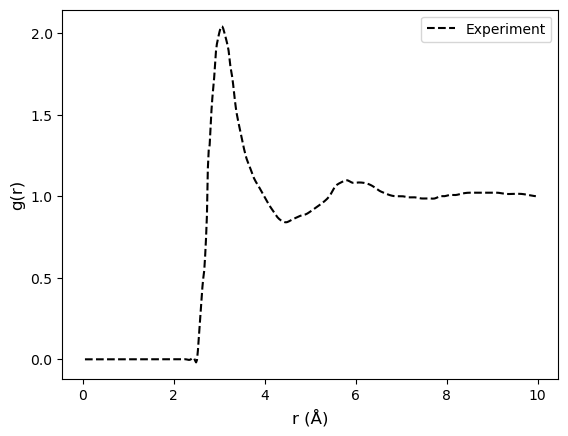

In [3]:
#Read in structure data
data   = pd.read_csv ('data/rdf_ne42K.csv') 
g_r    = pd.DataFrame (data, columns = ['r','g']) 
expRDF = g_r.values 
r, rdf = zip(*expRDF) 

#Interpolate experimental radial distribution
r_points = 500                                       #number of points in rdf and tabulated potential
exp_r    = np.linspace(r[0], r[-1], r_points)        #divide by 10 to convert from Å to nm
sp       = interpolate.splrep(np.array(r), rdf, s=0)
exp_rdf  = interpolate.splev(exp_r, sp, der=0)

plt.plot(exp_r, exp_rdf, color = 'k', label = 'Experiment', linestyle = '--')
plt.xlabel('r (Å)', fontsize = 12)
plt.ylabel('g(r)'  , fontsize = 12)
plt.legend()
plt.show()

In [4]:
#Define particle
name = "Ne"

#Thermodynamic state variables
k   = 3.29982916e-27 #boltzmann constant,   [kcal/K/particle]   
av  = 6.0223e23      #avagadro number,      [particle/mol]  
T   = 42             #temperature,          [K]
kbT = k * av * T     #thermal energy,       [kcal/mol]
ρ   = 0.02477        #experimental density, [particle/Å^3]  

#Simulation settings
δt    = 0.002        #timestep, [~0.5 ps] -> δt = 0.01 => δt ~ 5 fs
eq    = 1e4          #total equilibration timesteps, []
prod  = 1e5          #total production timesteps, []

#Mie reference potential parameters 
#Note that the reference potential should not be shifted too far to the right (higher r) or the SOPR potential may not update properly 
ref_n = 12           #repulsion exponent,   []
ref_ϵ = 0.122        #dispersion energy,    [kcal/mol]
ref_σ = 2.76         #collision diameter,   [Å]

#Select a reference potential (we will use an (n-6) Mie potential)
def mie_pot(r, n, ϵ, σ):
    return (n/(n-6))*(n/6)**(6/(n-6))*ϵ*((σ/r)**n - (σ/r)**6)

In [5]:
#Structure-optimized potential refinement settings
sopr_r_init   = np.ones(len(exp_rdf))  #reference simulated r-values
sopr_rdf_init = np.ones(len(exp_rdf))  #reference simulated rdf 
γ             = 0.25                   #scaling constant to improve numerical stability  
it_number  = list()                    #used to keep track of iteration
sum_cont   = np.zeros(len(exp_r))      #continuous sum of the difference in the rdfs from SOPR equation
rdf_diff   = np.ones(len(exp_rdf))     #temporary rdf difference function to calculate sum-of-square residuals 
track_ssr  = list()                    #track sum-of-square residuals between experimental and simulated rdf
tolerance  = 1.0e-3                    #defined as average ssr = ssr/(number of points in rdf) (default = 0.0001) 
iterations = 10                        #max number of iterations. Added to terminate program if not converged  

In [6]:
for i in range (iterations):
    it_number.append(i)                                                
    print(i)
    
    #Initialize SOPR with Mie potential simulation 
    if i == 0:  
        mie_fluid(it = i, m = 7, spacing = 1.5, name = name, timestep = δt, 
                  n = ref_n, sigma = ref_σ, epsilon = ref_ϵ, kbT = kbT, density = ρ, 
                  eq_time = eq, production_time = prod)
        
        #compute rdf
        rdf, normalization = intermolecular_rdf(gsdfile = 'traj/mie' + str(i) + '.gsd', A_name = name, B_name = name, 
                                                start = 0, stop = None, r_max = exp_r[-1], r_min = exp_r[0], 
                                                bins = r_points, exclude_bonded = False)
        sopr_r_init   = rdf.bin_centers
        sopr_rdf_init = rdf.rdf
        sopr_r        = rdf.bin_centers
        sopr_rdf      = rdf.rdf
    
    else:
        rmin = exp_r[0]
        rcut = exp_r[-1]
        table_fluid(it = i, m = 7, spacing = 2, name = name, timestep = δt, 
        kbT = kbT, density = ρ, eq_time = eq, production_time = prod,
        V = V, F = F, rmin = rmin, rcut = rcut)
        
        #compute rdf
        rdf, normalization = intermolecular_rdf(gsdfile = 'traj/traj' + str(i) + '.gsd', A_name = name, B_name = name, 
                                                start = 0, stop = None, r_max = exp_r[-1], r_min = exp_r[0], 
                                                bins = r_points, exclude_bonded = False)
        sopr_r   = rdf.bin_centers
        sopr_rdf = rdf.rdf    
    delg            = np.zeros(len(sopr_r))    #temporary rdf difference function added to continuous sum 
    new_potential   = np.zeros(len(sopr_rdf))  #tabulated potential updated with SOPR equation 
    ϕ               = []                       #new variable for tabulated potential to accomodate Gaussian process 
    GP_r            = []                       #r-values where the Gaussian process is applied
    GP              = []                       #Gaussian process regressed tabulated potential array

    #Numerical implementation of SOPR equation
    for j in range (len(sopr_r)):
        if sopr_r[j] <= 0.9*ref_σ:
            ϕ.append(mie_pot(sopr_r[j], ref_n, ref_ϵ, ref_σ))
        else:
            delg[j]          = (exp_rdf[j] - sopr_rdf[j])*kbT*γ                  #refinement equation
            sum_cont[j]      = sum_cont[j] + delg[j]
            new_potential[j] = mie_pot(sopr_r[j], ref_n, ref_ϵ, ref_σ) - sum_cont[j]
            GP_r.append(sopr_r[j])
            GP.append(new_potential[j])
            
    Rdd = inv_radius(np.array(GP_r, dtype='float64'), np.array(GP_r, dtype='float64'))  
    #inverse squared-exponential kernel gives a function that has a short length scale near the potential bowl and long length scale tail
    Kdd = ise_kernel(w = 0.01, ℓ = 4.3, R = Rdd)
    #the length-scale hyperparameter l_hyp should be chosen roughly where the potential transitions from short to long range
    μ_post, σ_post = gpr_ise(Kdd, GP_r, GP, yinf_min = GP_r[0], 
                             yinf_max = GP_r[-1], y_bins = len(GP_r), w_hyp = 0.01, l_hyp = 4.3)
    
    #append Gaussian process regressed points to preserved points at lower-r
    for l in range (len(GP)):
        ϕ.append(μ_post[l])
    
    #Use interpolate command to move data into proper format and calculate numerical derivative (force)
    sp  =  interpolate.splrep(sopr_r, ϕ, s=0)
    V   =  interpolate.splev (sopr_r, sp, der=0)
    F   = -interpolate.splev (sopr_r, sp, der=1)

    #Check for convergence
    sum_squares = 0
    for k in range (len(sopr_r)):                     
        rdf_diff[k] = exp_rdf[k] - sopr_rdf[k]
        sum_squares += rdf_diff[k]**2          #sum-of-square residuals between simulated and experimental data
    
    track_ssr.append(sum_squares/len(exp_r))
    print(track_ssr[i])
    if track_ssr[i] <= tolerance:
        print("Convergence Tolerance Reached")
        break

0


/opt/anaconda3/envs/sopr/lib/python3.12/site-packages/hoomd/update/box_resize.py:147: FutureWarning: box1, box2, and variant are deprecated, use `box`
  warnings.warn('box1, box2, and variant are deprecated, use `box`',


0.17098037933724322
1
0.003859860919339566
2
0.0029119499704561643
3
0.0023827225839938037
4
0.002008044645483126
5
0.0018346485730801698
6
0.0016146191130719963
7
0.0013564148304580752
8
0.0011433870795457698
9
0.001112947883582527


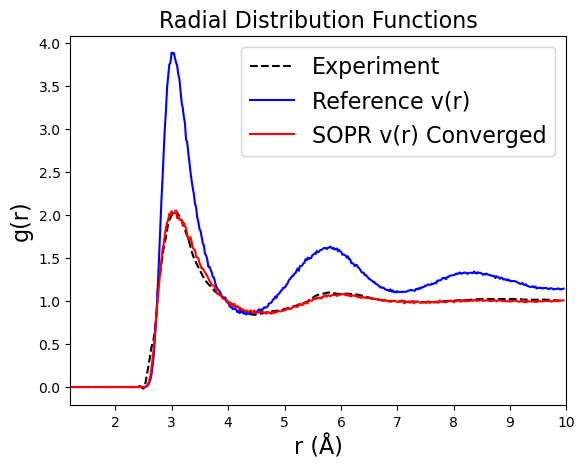

In [7]:
plt.plot(exp_r, exp_rdf, label = 'Experiment', color = 'k', linestyle = '--')
plt.plot(sopr_r_init, sopr_rdf_init, label = 'Reference v(r)', color = 'b')
plt.plot(sopr_r, sopr_rdf, label = 'SOPR v(r) Converged', color = 'r')
plt.xlim(1.2, 10)
plt.xlabel('r (Å)', fontsize = 16)
plt.ylabel('g(r)', fontsize = 16)
plt.title('Radial Distribution Functions', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

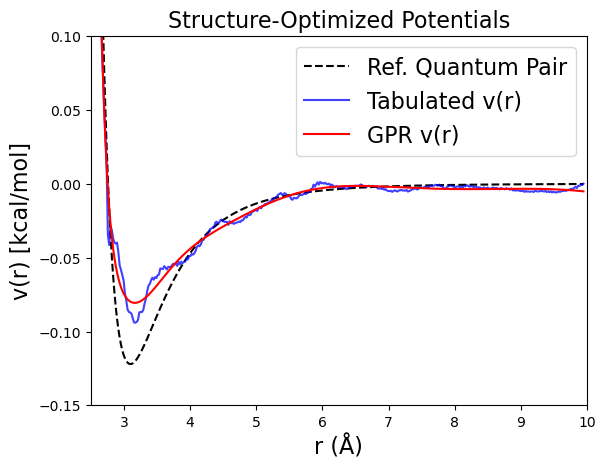

In [9]:
plt.plot(sopr_r, mie_pot(sopr_r, ref_n, ref_ϵ, ref_σ), label = 'Ref. Quantum Pair', color = 'k', linestyle = '--')
plt.plot(GP_r, GP - GP[-1], label = 'Tabulated v(r)', color = 'b', alpha = 0.75)
plt.plot(sopr_r, V, label = 'GPR v(r)', color = 'r')
plt.xlim(2.5, 10)
plt.ylim(-0.15, 0.1)
plt.xlabel('r (Å)', fontsize = 16)
plt.ylabel('v(r) [kcal/mol]', fontsize = 16)
plt.title('Structure-Optimized Potentials', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

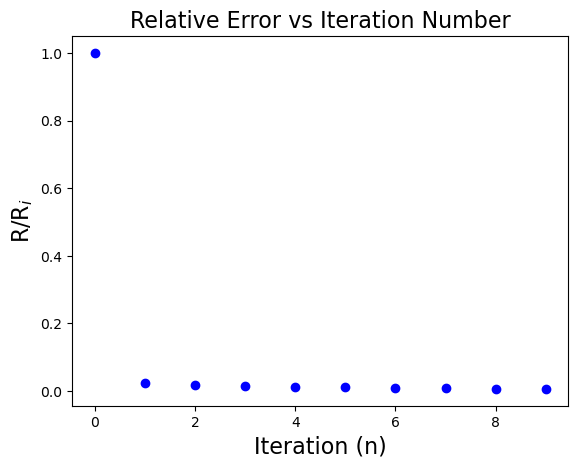

In [11]:
plt.scatter(it_number, track_ssr/track_ssr[0], color = 'blue')
plt.xlabel('Iteration (n)', fontsize = 16)
plt.ylabel('R/R$_i$', fontsize = 16)
plt.title('Relative Error vs Iteration Number', fontsize = 16)
plt.show()

In [13]:
from pickle import dump, load
output_dict = dict(exp_r = exp_r, exp_rdf = exp_rdf, sopr_r = sopr_r, rdf_init = sopr_rdf_init, rdf = sopr_rdf, pot = V) 
dump(output_dict, open('ne_sopr42K.p', 'wb'))